In [0]:
from statsmodels.tsa.stattools import adfuller
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Helper Function

In [0]:
def getScaledTrainTextDataset(dataset_scaled, trainRate=0.3):
    print('Shape: ',dataset_scaled.shape)
    train_size = int(len(dataset_scaled)*trainRate)
    test_size = len(dataset_scaled) - train_size
    print('Trainsize:',train_size, ' - Testsize:',test_size)
    train_start_index,train_end_index = 0,train_size
    test_start_index,test_end_index = train_size,len(dataset_scaled)
    train = dataset_scaled[0:train_size]
    test = dataset_scaled[train_size:] 
    return train,test

# convert an array of values into a dataset matrix
def create_XY_lookback_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return numpy.array(dataX), numpy.array(dataY)

def create_XY_lookback_dataset_multistepOutput(dataset, look_back=1, look_forward = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1-look_forward):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
	return numpy.array(dataX), numpy.array(dataY)

def calculateRMSE(testPredict,trainY,testY,inverse_transform=True, verbose= 1):
    
    if inverse_transform:
        testPredict_inverse = scaler.inverse_transform(testPredict)
        testY_inverse = scaler.inverse_transform([testY])  
    else:
        testPredict_inverse = testPredict
        testY_inverse = testY
        
    # calculate root mean squared error
    testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict_inverse[:,0]))
    if verbose == 1:
        print('Test Score: %.2f RMSE' % (testScore))
        print('Persistent Model Testscore small:',global_testPredict_small, ' - Persistent Model Testscore big:', global_testPredict_big)
        
    return  testScore

def calculateRMSE_MultipleOutput(trainPredict,testPredict,trainY,testY,inverse_transform=True, verbose= 1):
    
    if inverse_transform:
        trainPredict_inverse = scaler.inverse_transform(trainPredict)
        trainY_inverse = scaler.inverse_transform(trainY)
        testPredict_inverse = scaler.inverse_transform(testPredict)
        testY_inverse = scaler.inverse_transform(testY)  
    else:
        trainPredict_inverse = trainPredict
        trainY_inverse = trainY
        testPredict_inverse = testPredict
        testY_inverse = testY
        
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict_inverse[:,0]))
    testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict_inverse[:,0]))
    if verbose == 1:
        print('Train Score: %.2f RMSE' % (trainScore))
        print('Test Score: %.2f RMSE' % (testScore))
        print('Persistent Model Testscore small:',global_testPredict_small, ' - Persistent Model Testscore big:', global_testPredict_big)
        
    return trainScore, testScore

def plotErrorPrediction(dataset_scaled, testPredict, trainPredict, ShowTestError=True, inverse_transform=True):
    if inverse_transform:
        trainPredict_inverse = scaler.inverse_transform(trainPredict)
        testPredict_inverse = scaler.inverse_transform(testPredict)
    else:
        trainPredict_inverse = trainPredict
        testPredict_inverse = testPredict

    # shift train predictions for plotting
    trainPredictPlot = numpy.zeros_like(dataset_scaled)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict_inverse
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset_scaled)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict_inverse    
    
    error_test = dataset-testPredictPlot
    error_test[np.isnan(error_test)] = 0.
    # error_test[error_training<2000] = 0.
    error_test = np.abs(error_test)
    import seaborn as sns
    sns.distplot(error_test[error_test!=0])
    print(pandas.DataFrame(error_test[error_test!=0]).describe())
    return error_test, trainPredictPlot,testPredictPlot

def plotErrorPredictionValidation(dataset_scaled, validationPredict, testPredict, trainPredict, ShowTestError=True, inverse_transform=True):
    if inverse_transform:
        trainPredict_inverse = scaler.inverse_transform(trainPredict)
        testPredict_inverse = scaler.inverse_transform(testPredict)
    else:
        trainPredict_inverse = trainPredict
        testPredict_inverse = testPredict

    # shift train predictions for plotting
    trainPredictPlot = numpy.zeros_like(dataset_scaled)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict_inverse
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset_scaled)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1+len(validationPredict):len(dataset)-1, :] = testPredict_inverse    
    
    error_test = dataset-testPredictPlot
    error_test[np.isnan(error_test)] = 0.
    # error_test[error_training<2000] = 0.
    error_test = np.abs(error_test)
    import seaborn as sns
    sns.distplot(error_test[error_test!=0])
    print(pandas.DataFrame(error_test[error_test!=0]).describe())
    return error_test, trainPredictPlot,testPredictPlot

# MLP

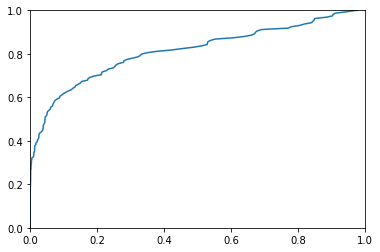

AUC:  0.7909231284433591
Time:  0:00:18.979555
Inference Time:  0:00:00.561702


In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Conv1D,MaxPooling1D,Flatten
seed(42)

def warn(*args, **kwargs):
    pass
    
class MLP_AnomalyDetection:
    def __init__(self,path, window_width,  n_epochs, train_rate):

        self.n_epochs = n_epochs
        self.window_width = window_width

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  


    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()



    def compute_anomalyScores(self):
        set_random_seed(42)
        seed(42)

        self.model = Sequential()
        self.model.add(Dense(100, activation='relu', input_dim=self.window_width))
        self.model.add(Dense(50, activation='relu', input_dim=self.window_width))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mse')
        self.model.fit(self.train_X, self.train_y, epochs=self.n_epochs, verbose=0)
        self.predictions = self.model.predict(self.test_X)

        # xgb = XGBRegressor()
        # xgb.fit(self.train_X.reshape(-1,1),self.train_y.reshape(-1,1))

        self.predictions = self.model.predict(self.test_X)
        # rmse = sqrt(mean_squared_error(self.test, self.predictions))
        # self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)        
   

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)
import os
import datetime

startTime = datetime.datetime.now()

mlp = MLP_AnomalyDetection('drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv',30,10,0.3)
mlp.fit()
mlp.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)


startTime = datetime.datetime.now()
mlp.model.predict(mlp.test_X)
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Inference Time: ',diff)


## Evaluation

### Results of UD1 - UD4

In [0]:


        
import os
import datetime
startTime = datetime.datetime.now()

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        mlp = MLP_AnomalyDetection( file,30,50,0.3)
        mlp.fit()
        print(file,end=' - ')
        dfs[j].loc[i] = [os.path.basename(file),mlp.get_roc_auc(plot=False,verbose=False)]


endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())    

drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv - AUC:  0.24584631360332293
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_11.csv - AUC:  0.9739266282389699
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_12.csv - AUC:  0.8643807574206755
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv - AUC:  0.8932761199905518
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_13.csv - AUC:  0.7826680313886045
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_15.csv - AUC:  0.7322159672466736
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_17.csv - AUC:  0.7453644165959815
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv - drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Ben

# CNN

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Conv1D,MaxPooling1D,Flatten
seed(42)

def warn(*args, **kwargs):
    pass
    
class CNN_AnomalyDetection:
    def __init__(self,path, window_width,  n_epochs, train_rate):

        self.n_epochs = n_epochs
        self.window_width = window_width

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  


    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()



    def compute_anomalyScores(self):

        self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],1,self.train_X.shape[1]))
        self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],1, self.test_X.shape[1]))

        from keras.layers import Conv1D,MaxPooling1D,Flatten
        self.model = Sequential()
        self.model.add(Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=(1, self.window_width),data_format='channels_first', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(1, self.window_width),data_format='channels_first', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(1, self.window_width),data_format='channels_first', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Flatten())
        self.model.add(Dense(40, activation='relu'))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mse')
        self.model.fit(self.train_X, self.train_y, epochs=self.n_epochs, verbose=0)
        self.predictions = self.model.predict(self.test_X)
        

    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)        
   

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# mlp = CNN_AnomalyDetection('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_9.csv',30,50,0.3)
# mlp.fit()
# mlp.plot()
# mlp.get_roc_auc(verbose=True)

## Evaluation

In [0]:


import os
import datetime

startTime = datetime.datetime.now()

import glob


# cnn = CNN_AnomalyDetection( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv',50,80,0.3)
# cnn.fit()
# cnn.get_roc_auc(plot=False,verbose=False)
cnn.model.predict(cnn.test_X)
        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

Time:  0:00:00.678285


### Results of UD1 - UD4

In [0]:
import os
import datetime

startTime = datetime.datetime.now()

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        cnn = CNN_AnomalyDetection( file,30,50,0.3)
        cnn.fit()
        dfs[j].loc[i] = [os.path.basename(file),cnn.get_roc_auc(plot=False,verbose=False)]

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_9.csv - AUC:  0.49653477822580655
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_8.csv - AUC:  0.9701973001038422
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_64.csv - drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_66.csv - AUC:  0.9678103125308095
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_67.csv - AUC:  0.9686515437933206
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_7.csv - AUC:  0.8824643129563037
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_65.csv - AUC:  0.9396541225185726
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_63.csv - AUC:  0.8336105424769703
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Bench

In [0]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.809449
std     0.160553
min     0.249270
25%     0.748016
50%     0.833611
75%     0.926711
max     0.991273
              auc
count  100.000000
mean     0.749240
std      0.077320
min      0.564315
25%      0.698003
50%      0.749798
75%      0.802242
max      0.931017
             auc
count  99.000000
mean    0.582761
std     0.129915
min     0.233515
25%     0.485761
50%     0.589447
75%     0.667649
max     0.954148
             auc
count  98.000000
mean    0.581019
std     0.118105
min     0.266463
25%     0.502420
50%     0.575858
75%     0.646015
max     0.873581


# CNN with BatchNormalization


In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, BatchNormalization, Activation,MaxPooling1D
import keras.layers

def warn(*args, **kwargs):
    pass
    
class CNNBatch_AnomalyDetection:
    def __init__(self,path, window_width,  n_epochs, train_rate):

        self.n_epochs = n_epochs
        self.window_width = window_width

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  


    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
        print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()



    def compute_anomalyScores(self):

        self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],1,self.train_X.shape[1]))
        self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],1, self.test_X.shape[1]))

        channel_pos = 'channels_first'
        inp_shape = Input((1, self.window_width),name='input1')
        x = Conv1D(32, kernel_size=1, padding = 'same', input_shape=(1, self.window_width),data_format=channel_pos,name='conv2d_Prep')(inp_shape)
        x = BatchNormalization(axis=1,name='batch_normalization_prep')(x)
        x_a1 = Activation('relu',name='activation_prep')(x)
        activated_x = x_a1

        nr = 1 *2 -1
        x = Conv1D(32, kernel_size=1, name = 'conv2d_'+str(nr), padding='same',data_format=channel_pos)(activated_x)
        x = BatchNormalization(axis=1, name = 'batch_normalization_'+str(nr))(x)
        activated_x = Activation('relu',name='activation_'+str(nr+1))(x)
        activated_x = Flatten()(activated_x)
        activated_x = Dense(50)(activated_x)
        output = Dense(1)(activated_x)

        from keras.models import Model
        self.model = Model(inp_shape,output )

        self.model.compile(optimizer='adam', loss='mse')
        self.history =self.model.fit(self.train_X, self.train_y, epochs=self.n_epochs, verbose=2)
        
        self.predictions = self.model.predict(self.test_X)

    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)        
   

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size - self.window_width]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )

# mlp = CNNBatch_AnomalyDetection('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',30,100,0.66)
# mlp.fit()
# mlp.plot()
# mlp.get_roc_auc(verbose=False)

## Evaluation

### Results of UD1 - UD4

In [0]:
import os
dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        cnn = CNNBatch_AnomalyDetection( file,30,150,0.3)
        cnn.fit()
        dfs[j].loc[i] = [os.path.basename(file),cnn.get_roc_auc(plot=False,verbose=False)]

drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv - Prediction Test RMSE: 1.019
AUC:  0.9827178962286434
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_12.csv - Prediction Test RMSE: 1.184
AUC:  0.8536335721596724
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv - Prediction Test RMSE: 1.293
AUC:  0.6902907580477674
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_11.csv - Prediction Test RMSE: 0.902
AUC:  0.7774605397834401
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_15.csv - Prediction Test RMSE: 0.519
AUC:  0.8425665301944729
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv - Prediction Test RMSE: 0.882
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_17.csv - Prediction Test RMSE: 1.539
AUC:  0.69507985151540

# CNN Residual Blocks

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, BatchNormalization, Activation,MaxPooling1D
import keras.layers

def warn(*args, **kwargs):
    pass
    
class CNNResidual_AnomalyDetection:
    def __init__(self,path, window_width,  n_epochs, train_rate):

        self.n_epochs = n_epochs
        self.window_width = window_width

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  


    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
        print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()



    def compute_anomalyScores(self):

        self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],1,self.train_X.shape[1]))
        self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],1, self.test_X.shape[1]))

        channel_pos = 'channels_first'
        inp_shape = Input((1, self.window_width),name='input1')
        x = Conv1D(256, kernel_size=3, padding = 'same', input_shape=(1, self.window_width),data_format=channel_pos,name='conv2d_Prep')(inp_shape)
        x = BatchNormalization(axis=1,name='batch_normalization_prep')(x)
        x_a1 = Activation('relu',name='activation_prep')(x)
        activated_x = x_a1

        #     activated_x, x
        nr = 1 *2 -1
        x = Conv1D(256, kernel_size=3, name = 'conv2d_'+str(nr), padding='same',data_format=channel_pos)(activated_x)
        x = BatchNormalization(axis=1, name = 'batch_normalization_'+str(nr))(x)
        x = Activation('relu',name = 'activation_'+str(nr))(x)
        x = Conv1D(256, kernel_size=3, name = 'conv2d_'+str(nr+1),padding = 'same',data_format=channel_pos)(x)
        x = BatchNormalization(axis=1, name = 'batch_normalization_'+str(nr+1))(x)
        x = keras.layers.add([x,activated_x],name='add_' + str(1))
        activated_x = Activation('relu',name='activation_'+str(nr+1))(x)
        activated_x = Flatten()(activated_x)
        activated_x = Dense(50)(activated_x)
        output = Dense(1)(activated_x)

        from keras.models import Model
        self.model = Model(inp_shape,output )

        self.model.compile(optimizer='adam', loss='mse')
        self.history =self.model.fit(self.train_X, self.train_y, epochs=self.n_epochs, verbose=2)
        
        self.predictions = self.model.predict(self.test_X)

    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)        
   

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size - self.window_width]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )


## Evaluation

In [0]:
import os
import datetime
startTime = datetime.datetime.now()

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        cnn = CNNResidual_AnomalyDetection( file,30,50,0.3)
        cnn.fit()
        dfs[j].loc[i] = [os.path.basename(file),cnn.get_roc_auc(plot=False,verbose=False)]

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)        

drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv - AUC:  0.7557113187954309
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_11.csv - AUC:  0.9045682271184614
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_12.csv - AUC:  0.7681678607983623
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv - AUC:  0.9840563735138965
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_13.csv - AUC:  0.9320482201751393
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_15.csv - AUC:  0.7294651995905834
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_17.csv - AUC:  0.679770797420673
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv - drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Bench

### Results of UD1 - UD4


In [0]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())


             auc
count  59.000000
mean    0.819109
std     0.145845
min     0.360557
25%     0.735841
50%     0.849219
75%     0.932614
max     0.993840
              auc
count  100.000000
mean     0.721279
std      0.122199
min      0.231962
25%      0.661307
50%      0.736486
75%      0.792401
max      0.975622
             auc
count  99.000000
mean    0.575338
std     0.130710
min     0.271470
25%     0.489538
50%     0.580895
75%     0.656831
max     0.954585
             auc
count  98.000000
mean    0.568564
std     0.129766
min     0.284061
25%     0.495022
50%     0.553821
75%     0.634201
max     0.948472


# Wavenet

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, BatchNormalization, Activation,MaxPooling1D
import keras.layers

def warn(*args, **kwargs):
    pass
    
class Wavenet_AnomalyDetection:
    def __init__(self,path, window_width,  n_epochs, train_rate):

        self.n_epochs = n_epochs
        self.window_width = window_width

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  


    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
        print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()



    def compute_anomalyScores(self):

        self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],1,self.train_X.shape[1]))
        self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],1, self.test_X.shape[1]))

        self.model = Sequential()
        self.model.add(Conv1D(filters=24, kernel_size=2, activation='relu', input_shape=(1, self.window_width),data_format='channels_first', padding='same', dilation_rate=1))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(filters=24, kernel_size=2, activation='relu', input_shape=(1, self.window_width),data_format='channels_first', padding='same', dilation_rate=2))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(filters=24, kernel_size=2, activation='relu', input_shape=(1, self.window_width),data_format='channels_first', padding='same', dilation_rate = 4))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(filters=24, kernel_size=2, activation='relu', input_shape=(1, self.window_width),data_format='channels_first', padding='same', dilation_rate = 8))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Flatten())
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mse')
        self.history =self.model.fit(self.train_X, self.train_y, epochs=self.n_epochs, verbose=0)
        
        self.predictions = self.model.predict(self.test_X)

    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)        
   

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)
# mlp = Wavenet_AnomalyDetection('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv',30,100,0.3)
# mlp.fit()
# mlp.plot()
# mlp.get_roc_auc(verbose=False)

0.AUC:  0.9979231568016613

## Evaluation

### Results of UD1 - UD4

In [0]:
import os
import datetime
startTime = datetime.datetime.now()

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        wavenet = Wavenet_AnomalyDetection( file,30,50,0.3)
        wavenet.fit()
        dfs[j].loc[i] = [os.path.basename(file),wavenet.get_roc_auc(plot=False,verbose=False)]

endTime = datetime.datetime.now()
diff = endTime - startTime
diff.seconds

drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv - AUC:  0.7268951194184838
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_11.csv - AUC:  0.9778053116414371
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_12.csv - AUC:  0.8165301944728761
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv - AUC:  0.9645303519407921
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_13.csv - AUC:  0.8090526555214375
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_15.csv - AUC:  0.7214048106448311
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_17.csv - AUC:  0.7309241068578362
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv - drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benc

17252

In [0]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.823900
std     0.151744
min     0.329581
25%     0.741180
50%     0.869632
75%     0.944101
max     0.993326
              auc
count  100.000000
mean     0.761423
std      0.074723
min      0.579357
25%      0.703060
50%      0.748934
75%      0.812097
max      0.963174
             auc
count  99.000000
mean    0.579589
std     0.139957
min     0.259389
25%     0.470602
50%     0.562991
75%     0.668086
max     0.974236
             auc
count  98.000000
mean    0.592414
std     0.135440
min     0.360844
25%     0.506269
50%     0.569758
75%     0.675437
max     0.934934


In [0]:
# import os
# import datetime
# startTime = datetime.datetime.now()

# dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
# files = []
# import glob
# folders = ['A1Benchmark']
# for j,folder in enumerate(folders):
#     for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
#         lstm = Wavenet_AnomalyDetection( file,30, 100,0.3)
#         lstm.fit()
#         print(file,end=' - ')
#         dfs[j].loc[i] = [os.path.basename(file),lstm.get_roc_auc(plot=False,verbose=False)]

# endTime = datetime.datetime.now()
# diff = endTime - startTime
# print('Time: ',diff.seconds)



import os
import datetime

startTime = datetime.datetime.now()

import glob


cnn = Wavenet_AnomalyDetection( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv',50,24,0.3)
cnn.fit()
cnn.get_roc_auc(plot=False,verbose=False)

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

startTime = datetime.datetime.now()
cnn.model.predict(cnn.test_X)        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Inference Time: ',diff)


Persistent Model RMSE: 1715.096
Train.len: 3095  - Test.len: 7224
TrainX.shape: (3044, 50)  - TestX.shape: (7173, 50)  - TrainY.shape: (3044,)  - TestY.shape: (7173,)
Prediction Test RMSE: 0.156
AUC:  0.7618006728586497
Time:  0:00:32.617373
Inference Time:  0:00:00.757158


In [0]:
dfs[0].describe()

,auc
count,59.000000
mean,0.824843
std,0.159040
min,0.257466
25%,0.762306
50%,0.878600
75%,0.941318
max,0.994610


# LSTM

Persistent Model RMSE: 867.478
Train.len: 938  - Test.len: 484
TrainX.shape: (907, 30)  - TestX.shape: (453, 30)  - TrainY.shape: (907,)  - TestY.shape: (453,)
Epoch 0 / 1
Epoch 1/1
907/907 [==============================] - 68s 75ms/step - loss: 0.0276
Prediction Test RMSE: 1.755


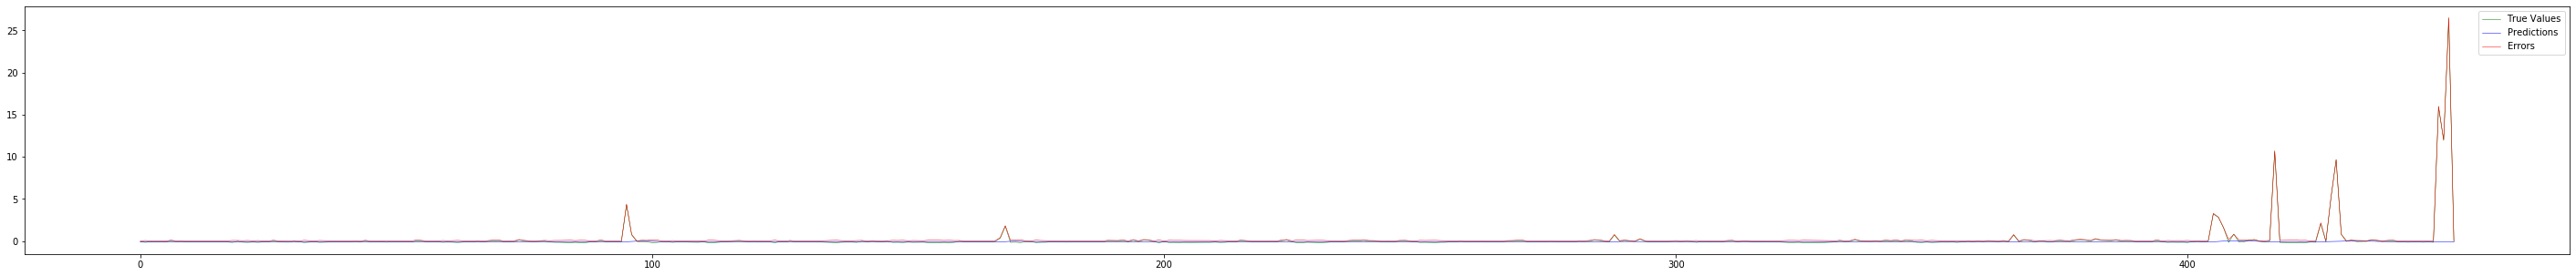

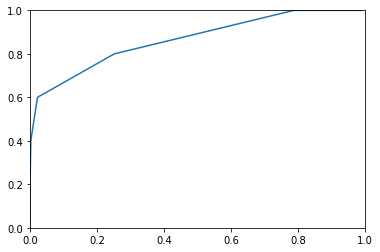

AUC:  0.8549668874172186


In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, BatchNormalization, Activation,MaxPooling1D, LSTM
import keras.layers

def warn(*args, **kwargs):
    pass
    
class LSTM_AnomalyDetection:
    def __init__(self,path, window_width,  n_epochs, train_rate):

        self.n_epochs = n_epochs
        self.window_width = window_width

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  


    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
        print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()



    def compute_anomalyScores(self):

        self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],self.train_X.shape[1],1))
        self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0], self.test_X.shape[1],1))

        self.model = Sequential()
        self.model.add(LSTM(4, batch_input_shape=(1, self.window_width, 1), stateful=True, return_sequences=True))
        self.model.add(LSTM(4, batch_input_shape=(1, self.window_width, 1), stateful=True))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mse')
        for i in range(self.n_epochs):
            print('Epoch',i, '/',self.n_epochs)
            self.model.fit(self.train_X, self.train_y, epochs=1, batch_size=1, verbose=1, shuffle=False)
            self.model.reset_states()
        # self.history =self.model.fit(self.train_X, self.train_y, epochs=self.n_epochs, verbose=2)
        
        self.predictions = self.model.predict(self.test_X, batch_size = 1)

    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)        
   

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size - self.window_width]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )

lstm = LSTM_AnomalyDetection('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',30,1,0.66)
lstm.fit()
lstm.plot()
lstm.get_roc_auc(verbose=False)

# GRU

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, BatchNormalization, Activation,MaxPooling1D, LSTM, GRU
import keras.layers

def warn(*args, **kwargs):
    pass
    
class GRU_AnomalyDetection:
    def __init__(self,path, window_width,  n_epochs, train_rate):

        self.n_epochs = n_epochs
        self.window_width = window_width

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  


    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()



    def compute_anomalyScores(self):

        self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],self.train_X.shape[1],1))
        self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0], self.test_X.shape[1],1))

        self.model = Sequential()
        self.model.add(GRU(4, batch_input_shape=(1, self.window_width, 1), stateful=True, return_sequences=True))
        self.model.add(GRU(4, batch_input_shape=(1, self.window_width, 1), stateful=True))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mse')
        for i in range(self.n_epochs):
            print('Epoch',i, '/',self.n_epochs, end=',')
            self.model.fit(self.train_X, self.train_y, epochs=1, batch_size=1, verbose=0, shuffle=False)
            self.model.reset_states()
        # self.history =self.model.fit(self.train_X, self.train_y, epochs=self.n_epochs, verbose=2)
        
        self.predictions = self.model.predict(self.test_X, batch_size = 1)

    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)        
   

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# gru = GRU_AnomalyDetection('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',30,4,0.66)
# gru.fit()
# gru.plot()
# gru.get_roc_auc(verbose=False)

Using TensorFlow backend.


## Evaluation

In [0]:
import os
import datetime
startTime = datetime.datetime.now()

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        gru = GRU_AnomalyDetection( file,30, 30,0.3)
        gru.fit()
        print(file,end=' - ')
        dfs[j].loc[i] = [os.path.basename(file),gru.get_roc_auc(plot=False,verbose=False)]

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)





Epoch 0 / 30,WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Epoch 1 / 30,Epoch 2 / 30,Epoch 3 / 30,Epoch 4 / 30,Epoch 5 / 30,Epoch 6 / 30,Epoch 7 / 30,Epoch 8 / 30,Epoch 9 / 30,Epoch 10 / 30,Epoch 11 / 30,Epoch 12 / 30,Epoch 13 / 30,Epoch 14 / 30,Epoch 15 / 30,Epoch 16 / 30,Epoch 17 / 30,Epoch 18 / 30,Epoch 19 / 30,Epoch 20 / 30,Epoch 21 / 30,Epoch 22 / 30,Epoch 23 / 30,Epoch 24 / 30,Epoch 25 / 30,Epoch 26 / 30,Epoch 27 / 30,Epoch 28 / 30,Epoch 29 / 30,drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv - AUC:  0.9810644831115659
Epoch 0 / 30,Epoch 1 / 30,Epoch 2 / 30,Epoch 3 / 30,Epoch 4 / 30,Epoch 5 / 30,Epoch 6 / 30,Epoch 7 / 30,Epoch 8 / 30,Epoch 9 / 30,Epoch 10 / 30,Epoch 11 / 3

# Autoencoder

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, BatchNormalization, Activation,MaxPooling1D, LSTM, GRU
import keras.layers
from keras import regularizers, Model

def warn(*args, **kwargs):
    pass
    
class AutoEncoder_AnomalyDetection:
    def __init__(self,path, window_width,  n_epochs, train_rate):

        self.n_epochs = n_epochs
        self.window_width = window_width

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)  


    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors

    def __build_sets(self):

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
        print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()



    def compute_anomalyScores(self):

        self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],self.train_X.shape[1],1))
        self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0], self.test_X.shape[1]),1)



        learning_rate = 1e-3
        input_layer = Input(shape=( 1,))
        encoder = Dense(64, activation="relu")(input_layer)
        encoder = Dense(32, activation="relu")(encoder)
        encoder = Dense(16, activation="relu")(encoder)
        decoder = Dense(16, activation="relu")(encoder)
        decoder = Dense(32, activation="relu")(decoder)
        decoder = Dense(64, activation="relu")(decoder)
        decoder = Dense(1, activation="linear")(decoder)
        self.model = Model(inputs=input_layer, outputs=decoder)
        self.model.compile(metrics=['accuracy'],
                            loss='mean_squared_error',
                            optimizer='adam')
        channel_pos = 'channels_first'


        history = self.model.fit(self.train_y, self.train_y, epochs=self.n_epochs, verbose=0)

        self.predictions = self.model.predict(self.test_y)

    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)        
   

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size - self.window_width]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )

# ae = AutoEncoder_AnomalyDetection('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv',30,100,0.66)
# ae.fit()
# ae.plot()
# ae.get_roc_auc(verbose=False)

## Evaluation

In [0]:
# import os
# import datetime
# startTime = datetime.datetime.now()

# dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
# files = []
# import glob
# folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
# for j,folder in enumerate(folders):
#     for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
#         print(file,end=' - ')
#         ae = AutoEncoder_AnomalyDetection( file,30,50,0.3)
#         ae.fit()
#         dfs[j].loc[i] = [os.path.basename(file),ae.get_roc_auc(plot=False,verbose=False)]

# endTime = datetime.datetime.now()
# diff = endTime - startTime
# diff.seconds



import os
import datetime

startTime = datetime.datetime.now()

import glob


cnn = AutoEncoder_AnomalyDetection( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv',30,50,0.3)
cnn.fit()
cnn.get_roc_auc(plot=False,verbose=False)

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

AUC:  0.5667031276914052
Time:  18


### Results of UD1 - UD4

In [0]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.782197
std     0.191842
min     0.284315
25%     0.698734
50%     0.856448
75%     0.922630
max     0.980526
              auc
count  100.000000
mean     0.742767
std      0.089602
min      0.400934
25%      0.701504
50%      0.749107
75%      0.794001
max      0.972640
             auc
count  99.000000
mean    0.602905
std     0.127171
min     0.320197
25%     0.508908
50%     0.602314
75%     0.680213
max     0.954585
             auc
count  98.000000
mean    0.597238
std     0.140469
min     0.316594
25%     0.507236
50%     0.582948
75%     0.673144
max     0.976638


In [0]:
import os
import datetime

startTime = datetime.datetime.now()

import glob


cnn = AutoEncoder_AnomalyDetection( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv',100,100,0.3)
cnn.fit()
cnn.get_roc_auc(plot=False,verbose=False)

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

Persistent Model RMSE: 1715.096
Train.len: 3095  - Test.len: 7224
TrainX.shape: (2994, 100)  - TestX.shape: (7123, 100)  - TrainY.shape: (2994,)  - TestY.shape: (7123,)
Prediction Test RMSE: 0.001
AUC:  0.5712048047029863
Time:  78


In [0]:
import os
import datetime

startTime = datetime.datetime.now()

import glob


cnn = AutoEncoder_AnomalyDetection( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv',100,200,0.3)
cnn.fit()
cnn.get_roc_auc(plot=False,verbose=False)

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)

Persistent Model RMSE: 1715.096
Train.len: 3095  - Test.len: 7224
TrainX.shape: (2994, 100)  - TestX.shape: (7123, 100)  - TrainY.shape: (2994,)  - TestY.shape: (7123,)
Prediction Test RMSE: 0.001
AUC:  0.6393921012364058
Time:  145


In [0]:

import os
import datetime

startTime = datetime.datetime.now()

import glob


cnn.model.predict(cnn.test_y)

        
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

Time:  0:00:00.540601
